# Import Libraries & Data

In [1]:
import numpy as np
import pandas as pd
from sklearn.cross_decomposition import CCA
from scipy import signal
import mne
import matplotlib.pyplot as plt

In [37]:
# data_path = '../../data/Katie_7-14_EEG_nofilter_cleaned.csv'
# data_path = '../../data/Katie_7_14_EEG_0.1_50HzBandpass_60HzNotch_cleaned.csv'
data_path = '../../data/Alex_7-14_EEG_OSCAR_cleaned.csv'
df = pd.read_csv(data_path)

In [38]:
df

,Unnamed: 0,EEG_Ch1(mV),EEG_Ch2(mV),EEG_Ch3(mV),EEG_Ch4(mV),EEG_Ch5(mV),EEG_Ch6(mV),EEG_Ch7(mV),EEG_Ch8(mV),Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,stim
0,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.010,0.951,-0.193,0.000,0.000,0.000,1.0,86.667,1.0,0.000,0.0
1,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.001,0.976,-0.207,0.000,0.000,0.000,2.0,86.667,1.0,9.317,0.0
2,2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.004,0.984,-0.207,0.000,0.000,0.000,3.0,86.667,1.0,4.313,0.0
3,3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.003,0.988,-0.207,0.000,0.000,0.000,4.0,86.667,1.0,0.007,0.0
4,4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.002,0.992,-0.206,0.000,0.000,0.000,5.0,86.667,1.0,1.922,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260438,260438,-1.878,-0.500,0.970,-3.123,5.850,16.104,4.656,2.176,0.000,1.012,-0.002,-0.092,1.740,0.946,260439.0,80.000,1.0,0.020,0.0
260439,260439,1.011,-0.773,3.079,-4.195,4.382,16.089,6.674,3.869,0.001,1.012,-0.003,-0.122,1.587,0.977,260440.0,80.000,1.0,1.877,0.0
260440,260440,3.901,-1.442,4.120,-4.205,2.913,15.201,9.579,4.187,0.001,1.011,-0.003,-0.092,1.556,1.038,260441.0,80.000,1.0,10.576,0.0
260441,260441,6.163,-2.557,3.735,-3.402,1.933,13.590,12.690,2.924,0.000,1.011,-0.002,-0.214,1.617,0.946,260442.0,80.000,1.0,0.011,0.0


In [39]:
channels = [f"EEG_Ch{i}(mV)" for i in range(5, 8)] # Select channels you want
eeg_data = df[channels].to_numpy()
y = df['stim'].to_numpy()

n_channels = eeg_data.shape[1]

# Filter Data

### MNE

In [66]:
sfreq = 250

info = mne.create_info(['EEG' for i in range(eeg_data.shape[1])], sfreq, ch_types='eeg')
raw = mne.io.RawArray(eeg_data.T, info)

# Apply bandpass filter
raw_bandpass = raw.copy().filter(l_freq=0.5, h_freq=50)

# Apply notch filter
raw_filtered = raw_bandpass.copy().notch_filter(freqs=60)

eeg_data = raw_filtered.get_data().T

/tmp/ipykernel_80813/827129882.py:3: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  info = mne.create_info(['EEG' for i in range(eeg_data.shape[1])], sfreq, ch_types='eeg')


### Scipy

In [44]:
# Define filter parameters
fs = 250
lowcut = 0.5  # Lower frequency of the bandpass
highcut = 50  # Upper frequency of the bandpass
notch_freq = 60  # Frequency to be removed by notch filter
Q = 30  # Quality factor for notch filter

In [45]:
# Create bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

In [46]:
# Create notch filter
def notch_filter(notch_freq, Q, fs):
    b, a = signal.iirnotch(notch_freq, Q, fs)
    return b, a

In [47]:
# Get filter coefficients
b_bandpass, a_bandpass = butter_bandpass(lowcut, highcut, fs)
b_notch, a_notch = notch_filter(notch_freq, Q, fs)

In [50]:
# Apply filters
signal_bandpass = signal.filtfilt(b_bandpass, a_bandpass, eeg_data.T)
eeg_data_filtered = signal.filtfilt(b_notch, a_notch, signal_bandpass)

In [52]:
eeg_data = eeg_data_filtered.T

# Epoch Data & CCA Analysis

In [67]:
class CCAAnalysis:
    """Canonical Correlation Analysis for SSVEP paradigm"""
    def __init__(self, freqs, win_len, s_rate, n_harmonics=1):
        """
        Args:
            freqs (list): List of target frequencies
            win_len (float): Window length
            s_rate (int): Sampling rate of EEG signal
            n_harmonics (int): Number of harmonics to be considered
        """
        self.freqs = freqs
        self.win_len = win_len
        self.s_rate = s_rate
        self.n_harmonics = n_harmonics
        self.train_data = self._init_train_data()
        self.cca = CCA(n_components=1)

    def _init_train_data(self):
        t_vec = np.linspace(0, self.win_len, int(self.s_rate * self.win_len))
        targets = {}
        for freq in self.freqs:
            sig_sin, sig_cos = [], []
            for harmonics in range(self.n_harmonics):
                sig_sin.append(np.sin(2 * np.pi * harmonics * freq * t_vec))
                sig_cos.append(np.cos(2 * np.pi * harmonics * freq * t_vec))
            targets[freq] = np.array(sig_sin + sig_cos).T
        return targets

    def apply_cca(self, eeg):
        """Apply CCA analysis to EEG data and return scores for each target frequency

        Args:
            eeg (np.array): EEG array [n_samples, n_chan]

        Returns:
            list of scores for target frequencies
        """
        scores = []
        for key in self.train_data:
            sig_c, t_c = self.cca.fit_transform(eeg, self.train_data[key])
            scores.append(np.corrcoef(sig_c.T, t_c.T)[0, 1])
        return scores

In [68]:
def get_epoch_idxs(arr, s_rate, t_len):
    result = []
    current_subarray = [arr[0]]
    
    for i in range(1, len(arr)):
        if arr[i] == arr[i-1] + 1:
            current_subarray.append(arr[i])
        else:
            if len(current_subarray) > s_rate*t_len:
                result.append(np.array(current_subarray[:int(s_rate*t_len)])) # cut off
            current_subarray = [arr[i]]
    
    # result.append(current_subarray)
    return result

In [64]:
t_min = -1
t_max = 6.
event_freq = [5, 12]
fs = 250

t_win = [.25, .5, .75, 1, 1.25, 1.5, 2, 2.5, 3, 4, 6]
# t_win = [2]

predictions = {str(key): [] for key in t_win}
accuracies = []

for tmax in t_win:
    cca = CCAAnalysis(freqs=event_freq, win_len=tmax, s_rate=250, n_harmonics=2)

    epochs = []
    idxs = []
    groundtruth = []

    for i in [1,2]:
        idxs.append(get_epoch_idxs(np.where(y == i)[0], s_rate=fs, t_len=tmax))

    for i in range(2):
        for idx in idxs[i]:
            epochs.append(eeg_data[idx])
            groundtruth.append(np.mean(y[idx]))

    for eeg_chunk in epochs:
        scores = cca.apply_cca(eeg_chunk)
        predictions[str(tmax)].append(np.argmax(scores))
        
    accuracies.append(
        np.count_nonzero(np.array(predictions[str(tmax)]) + 1 == groundtruth) / len(predictions[str(tmax)]) * 100)

In [69]:
accuracies

[42.857142857142854,
 42.857142857142854,
 42.857142857142854,
 41.83673469387755,
 41.83673469387755,
 42.857142857142854,
 42.857142857142854,
 42.857142857142854,
 44.89795918367347,
 45.91836734693878,
 47.88732394366197]

In [56]:
accuracies

[42.857142857142854,
 42.857142857142854,
 42.857142857142854,
 41.83673469387755,
 41.83673469387755,
 42.857142857142854,
 42.857142857142854,
 42.857142857142854,
 44.89795918367347,
 45.91836734693878,
 47.88732394366197]

# Time Frequency Analysis

In [70]:
epochs = np.array(epochs)
epochs = np.transpose(epochs , (0, 2, 1))

groundtruth = np.array(groundtruth)

In [71]:
epochs.shape

(71, 3, 1500)

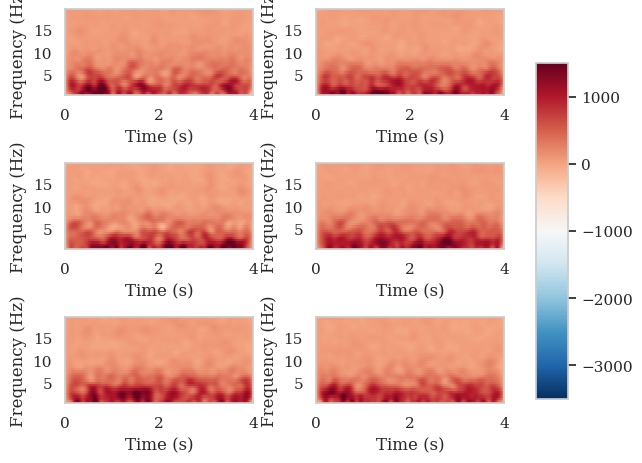

In [72]:
fs = 250
freqs = np.arange(0.5, 20., .5)
n_cycles = freqs

times = np.linspace(0, 4, np.array(epochs).shape[2])

power_1 = mne.time_frequency.tfr_array_morlet(epochs[np.where(groundtruth == 1.)[0], :, :], sfreq=fs,
                                                freqs=freqs, n_cycles=n_cycles, zero_mean=True,
                                                output='avg_power')
power_2 = mne.time_frequency.tfr_array_morlet(epochs[np.where(groundtruth == 2.)[0], :, :], sfreq=fs,
                                                freqs=freqs, n_cycles=n_cycles, zero_mean=True,
                                                output='avg_power')

mne.baseline.rescale(power_1, times, (None, 0), mode='mean', copy=False)
mne.baseline.rescale(power_2, times, (None, 0), mode='mean', copy=False)

power = np.stack([power_1, power_2])
x, y = mne.viz.centers_to_edges(times, freqs)

fig, ax = plt.subplots(n_channels, 2)
for j in range(2):
    for i in range(n_channels):
        mesh = ax[i, j].pcolormesh(x, y, power[j, i], cmap='RdBu_r', vmin=-3500, vmax=1500)
        # ax[i, j].set_title('TFR - ' + chan_name[i] + ' - ' + class_names[j])
        ax[i, j].set(ylim=freqs[[0, -1]], xlabel='Time (s)', ylabel='Frequency (Hz)')
plt.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(mesh, cax=cbar_ax)
plt.show()


# Test on Dataset

In [30]:
from sklearn.pipeline import make_pipeline

import moabb
from moabb.datasets import MAMEM3
from moabb.evaluations import WithinSessionEvaluation
from moabb.paradigms import SSVEP
from moabb.pipelines import SSVEP_CCA


# warnings.simplefilter(action="ignore", category=FutureWarning)
# warnings.simplefilter(action="ignore", category=RuntimeWarning)
moabb.set_log_level("info")

In [31]:
subj = [1, 3]
dataset = MAMEM3()
dataset.subject_list = subj

In [32]:
paradigm = SSVEP(fmin=3, fmax=15, n_classes=3)

2024-07-14 17:09:30,742 WARNING MainThread moabb.paradigms.ssvep Choosing the first 3 classes from all possible events


In [33]:
interval = dataset.interval
freqs = paradigm.used_events(dataset)

pipeline = {}
pipeline["CCA"] = make_pipeline(SSVEP_CCA(interval=interval, freqs=freqs, n_harmonics=3))

In [34]:
sessions = dataset.get_data(subjects=[3])
X, labels, meta = paradigm.get_data(dataset=dataset, subjects=[3])

MNE_DATA is not already configured. It will be set to default location in the home directory - /home/daniel/mne_data
All datasets will be downloaded to this location, if anything is already downloaded, please move manually to this location


/home/daniel/mambaforge/envs/eeg-notebooks/lib/python3.9/site-packages/moabb/datasets/download.py:55: RuntimeWarning: Setting non-standard config type: "MNE_DATASETS_MAMEM3_PATH"
  set_config(key, get_config("MNE_DATA"))
/home/daniel/mambaforge/envs/eeg-notebooks/lib/python3.9/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs |  5 events (all good), 1 – 4 s, baseline off, ~236 kB, data loaded,
 '6.66': 3
 '7.50': 0
 '8.57': 2>
  warn(f"warnEpochs {epochs}")
/home/daniel/mambaforge/envs/eeg-notebooks/lib/python3.9/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs |  4 events (all good), 1 – 4 s, baseline off, ~194 kB, data loaded,
 '6.66': 1
 '7.50': 0
 '8.57': 3>
  warn(f"warnEpochs {epochs}")
/home/daniel/mambaforge/envs/eeg-notebooks/lib/python3.9/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs |  5 events (all good), 1 – 4 s, baseline off, ~236 kB, data loaded,
 '6.66': 3
 '7.50': 0


In [73]:
X.shape

(45, 14, 385)

In [75]:
labels

array(['8.57', '6.66', '6.66', '8.57', '6.66', '8.57', '8.57', '6.66',
       '8.57', '8.57', '6.66', '6.66', '8.57', '6.66', '8.57', '8.57',
       '6.66', '8.57', '8.57', '6.66', '6.66', '8.57', '6.66', '8.57',
       '8.57', '6.66', '8.57', '8.57', '6.66', '6.66', '8.57', '6.66',
       '8.57', '8.57', '6.66', '8.57', '8.57', '6.66', '6.66', '8.57',
       '6.66', '8.57', '8.57', '6.66', '8.57'], dtype='<U4')